# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generating linearly separable data

In [2]:
n = 8000
d = 100
tau = 0.1

# a.T x = 0
a = np.random.rand(d-1,1)
a = a / np.sum(a)
# a = np.zeros((d-1,1))

X = np.random.rand(n,d - 1) - 0.5
X0 = -np.dot(X[:int(n/2)], a) + np.random.rand(int(n/2),1) - tau
X1 = -np.dot(X[int(n/2):], a) + np.random.rand(int(n/2),1) + (tau + 1)
# X0 = -np.sum(X[:int(n/2)], axis=1, keepdims=True) + np.random.rand(int(n/2),1) - tau
# X1 = -np.sum(X[int(n/2):], axis=1, keepdims=True) + np.random.rand(int(n/2),1) + (tau + 1)
# X0 = np.random.rand(int(n/2),1) + tau
# X1 = np.random.rand(int(n/2),1) - (tau + 1)
Xd = np.concatenate((X0, X1), axis=0) 
X = np.concatenate((X, Xd), axis=1)
Y = np.concatenate((-np.ones((int(n/2),1)), np.ones((int(n/2),1))), axis=0)

In [3]:
print(X.shape)
print(Y.shape)

(8000, 100)
(8000, 1)


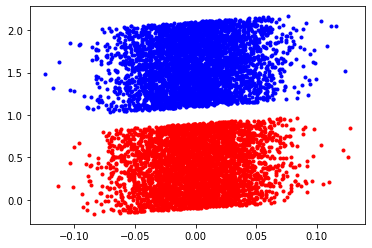

In [4]:
plt.plot(-np.dot(X[:int(n/2),:-1], a), X[:int(n/2), -1], 'r.')
plt.plot(-np.dot(X[int(n/2):,:-1], a), X[int(n/2):, -1], 'b.')
# plt.plot([0,1], [-tau, -tau], '--')
# plt.plot([0,1], [tau, tau], '--')
plt.show()

In [5]:
# Compute L
print(np.matmul(X.T,X).shape)
eigens = np.linalg.eigh(np.matmul(X.T,X))[0]
# print(np.linalg.eigh(np.matmul(X.T,X))[0][-1])
L = eigens[-1] # The eigenvalues in ascending order
print(L)

(100, 100)
11620.470349796627


In [6]:
epochs = 50

# SGD

In [7]:
def SGD(X, Y, epochs, lr):
    n, d = X.shape
    w = np.zeros((d,1))
    b = 0
    losses = []
    accs = []
    # epoch 0
    z = np.dot(X, w) + b
    pred = z > 0
    pred = pred * 2 - 1
    acc = np.mean(pred == Y)
    accs.append(acc)
    loss = np.mean(np.maximum(0, 1 - Y* z))
    losses.append(loss)
    
    cnt = 0 
    for epoch in range(epochs):
        for i in range(n):
            idx = np.random.randint(n)
            x = X[idx]
            x = np.expand_dims(x, axis=-1)
            y = Y[idx]
            J_w = 0
            J_b = 0
            if y*(np.dot(w.T,x) + b) < 1:    
                J_w = -y*x
                J_b = -y
                cnt += 1
            w = w - lr*J_w
            b = b - lr*J_b
            
        z = np.dot(X, w) + b
        pred = z > 0
        pred = pred * 2 - 1
        acc = np.mean(pred == Y)
        accs.append(acc)
        loss = np.mean(np.maximum(0, 1 - Y* z))
        losses.append(loss)
        
    return losses, accs

In [8]:
sgd_losses, sgd_accs = SGD(X, Y, epochs, 1/L)
print(sgd_losses)
print(sgd_accs)

[1.0, 0.7498490109202515, 0.6389622394654251, 0.5823445303803684, 0.5256388191182024, 0.46803463754516794, 0.4127971917743504, 0.35716753662965156, 0.316251509971264, 0.2867368718291125, 0.26511079140109606, 0.24751437768513693, 0.23289648762604895, 0.22055299033023634, 0.20989050841212975, 0.2006297940535918, 0.19230689050773828, 0.18512632518476582, 0.17865023439270186, 0.17269113710748626, 0.16750345096062882, 0.16239971532167238, 0.15781765772471013, 0.15363327656527623, 0.14970006974870334, 0.14590426563114772, 0.14234267438220075, 0.13906598088187197, 0.13593355971254037, 0.13298127489208877, 0.13019781100648822, 0.127535654843728, 0.1250834649054115, 0.12267324866224541, 0.12042597522306124, 0.11828375464212194, 0.11620128752578603, 0.11418863797355933, 0.11227468161746054, 0.11046642677404288, 0.10868976693634035, 0.10694690225442577, 0.10531667168684705, 0.10379276461213148, 0.10221636581068333, 0.10066803058691098, 0.09919733239512604, 0.09778767002933057, 0.09646162709479432

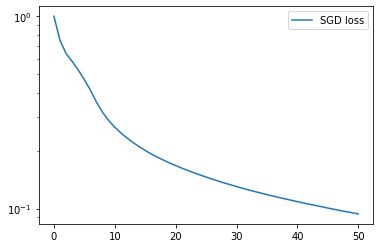

In [9]:
plt.plot(range(epochs + 1), sgd_losses)
plt.yscale('log')
plt.legend(['SGD loss'])

# Acc-SGD

In [10]:
def Acc_SGD(X, Y, epochs, rho, tau):
    eta = 1 / (L * rho)
    n, d = X.shape
    X = np.concatenate((X, np.ones((n,1))), axis=1)
    w = np.zeros((d+1,1))
    b = 0
    losses = []
    accs = []
    # update param
    v = np.zeros((d+1,1))
    zeta = np.zeros((d+1,1))
    gama = 0
    ak = 0.001
    beta = 1 # set mu = 0 (0-strong convex function is a convex function)
    
    # epoch 0
    z = np.dot(X, w) + b
    pred = z > 0
    pred = pred * 2 - 1
    acc = np.mean(pred == Y)
    accs.append(acc)
    loss = np.mean(np.maximum(0, 1 - Y* z))
    losses.append(loss)
    
    for epoch in range(epochs):
        for i in range(n):
            idx = np.random.randint(n)
            x = X[idx]
            x = np.expand_dims(x, axis=-1)
            y = Y[idx]
            # update
            gama = (1 / rho + np.sqrt(1 / rho**2 + 4*gama**2)) / 2
            alpha = gama * eta / (gama * eta + ak**2)
            ak = gama * np.sqrt(eta*rho)
            
            zeta = alpha * v + (1 - alpha) * w
            J_zeta = 0
            if y*(np.dot(zeta.T,x) + b) < 1:    
                J_zeta = -y*x
            v = beta * v + (1 - beta) * zeta - gama * eta * J_zeta
            w = zeta - eta * J_zeta
            
        z = np.dot(X, w) + b
        pred = z > 0
        pred = pred * 2 - 1
        acc = np.mean(pred == Y)
        accs.append(acc)
        loss = np.mean(np.maximum(0, 1 - Y* z))
        losses.append(loss)
        
    return losses, accs

In [11]:
acc_losses_10, acc_accs_10 = Acc_SGD(X, Y, epochs, 1 / (tau * 10), tau)
print(acc_losses_10)
print(acc_accs_10)

[1.0, 0.03565821799108268, 0.005249059413738002, 0.017374096511351106, 0.020316045188990908, 0.010576243342434396, 0.019752239441985567, 0.0202846463705664, 0.00905304272865408, 0.006577839125905225, 0.009268809772784072, 0.012409934864034746, 0.0033973706923789548, 0.003795271649396316, 0.020476420824327584, 0.013356933262766955, 0.018724210406453716, 0.022647592682825967, 0.017997125261266633, 0.0049006808220859064, 0.009288493740483213, 0.015820230178743174, 0.011386085312817642, 0.011705960101465447, 0.005217933100750529, 0.005656230212786727, 0.004285452059854581, 0.003385903531556412, 0.003235029665423916, 0.0042697836955965865, 0.0024335447184074006, 0.006476562216802236, 0.008906232029701236, 0.008012328469287457, 0.004693531931572895, 0.006357713651878161, 0.004120633010994105, 0.0025541262960818863, 0.0011496028566318941, 0.0027261048982084903, 0.004220573069036434, 0.0032570844853885743, 0.005043546031889378, 0.005132745707318666, 0.0030343459225803285, 0.002648711286946245,

In [12]:
acc_losses_1, acc_accs_1 = Acc_SGD(X, Y, epochs, 1 / tau, tau)
print(acc_losses_1)
print(acc_accs_1)

[1.0, 0.2511065739508125, 0.0771783113816634, 0.04249148527083625, 0.026710006493111324, 0.017813751169211516, 0.012597621238830478, 0.009310492203031207, 0.006609949887566001, 0.004796188875637647, 0.003347490743974925, 0.0023598584768696465, 0.0016272770225958966, 0.0011035209124443351, 0.0011813564210580464, 0.0008859003283127067, 0.0007390383612600098, 0.000806007655144263, 0.0006377119449990569, 0.0004250656736564218, 0.00038125299099322964, 0.00023609116960492148, 0.0001590448220349525, 0.00024275033788633205, 0.00018538010397213523, 0.00020445174767096065, 0.00015795110149205115, 0.00010989839765395914, 6.334940000908551e-05, 1.772220227551502e-05, 3.306582491395926e-05, 6.9793051331426e-05, 7.759376057708711e-05, 6.79955548103377e-05, 8.234764598806144e-05, 7.79278983769407e-05, 6.857354492419909e-05, 2.7775043619291394e-05, 1.0809827729726162e-05, 1.2970740681276682e-05, 5.5219077668069216e-05, 6.646617902715124e-05, 4.427913646938708e-05, 5.21594171240527e-05, 3.3830624996037

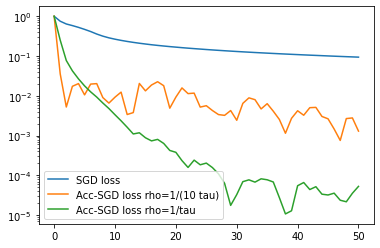

In [13]:
plt.plot(range(epochs+1), sgd_losses, range(epochs+1), acc_losses_10, range(epochs+1), acc_losses_1)
plt.yscale('log')
plt.legend(['SGD loss', 'Acc-SGD loss rho=1/(10 tau)', 'Acc-SGD loss rho=1/tau'])